In [204]:
import geopandas as gp 
import numpy as np 
import pylab as pl 

# Read the data 

In [205]:
n = gp.read_file('../maps/demnet.shp')
# n.set_index('LINKNO', inplace = True)
# n['np'] = 0
# for i in range(1,11):
#     n['us%d' % i] = -1

# Function that creates new set of parents that are not necesary binary

In [206]:
def binary2multiple_parents(net, max_nparents = 10, remove_lenght_zero = True, reset_index = True):
    '''This function takes as an argument "n" a GeoDataFrame describing the network obtained by TauDEM
    It returns the same dat with added np: number of parents, and us1...to us10 the upstream parents, 
    with this we can avoid using null links in HLM
    Parameters:
    - max_nparents is the total number of new parents
    - remove_lenght_zero (true), removes the links with StraightL==0
    - reset_index (false), the function makes LINKNO the index at the beggining, it brings them back to normal after end'''
    #Set index, and creates the numparents field and the fileds for the upstream parents
    net.set_index('LINKNO', inplace = True)
    net['np'] = 0
    for i in range(1,11):
        net['us%d' % i] = -1

    #Iterate through links
    for lid in net.index:

        #Gets the link downstream
        ld = net.loc[lid, 'DSLINKNO']

        #check if is not an outlet of the region or if it has lenght>0
        if ld > -1 and net.loc[lid, 'StraightL'] > 0:

            #Checks if the links downstream has no lenght
            if net.loc[ld,'StraightL'] == 0:
                #If has no length, iterates until reaching a link that has lenght
                flag = True
                while flag:
                    #Next lid downstream
                    ld = net.loc[ld, 'DSLINKNO']
                    if ld == -1: 
                        #Finish if reach an outlet
                        flag = False
                    elif net.loc[ld,'StraightL'] > 0:
                        #Finish if finds a lid with lenght>0
                        flag  = False

            if ld > -1:
                #Updates the number of parents 
                net.loc[ld, 'np']+=1

                #Add the parent
                nparent = net.loc[ld, 'np']
                net.loc[ld, 'us%d' % nparent] = lid
    if remove_lenght_zero:
        net = net[net.StraightL>0]
    if reset_index:
        net.reset_index(inplace = True)
    return net

## Example of the function

In [207]:
n2 = binary2multiple_parents(n, reset_index=False)

In [194]:
l = 6811

## Extracting a sub-watershed using the obtained network 

In [216]:
def get_subwatershed(net, link):
    '''Extracts the network corresponding to the watershed upstream of a link'''
    lids = [link]
    for lid in lids:
        nparents = net.loc[lid,'np']
        if nparents>0:
            lista = ['us%d' % i for i in range(1,nparents+1)]
            lids.extend(net.loc[lid,lista].values.tolist())
    return net.loc[lids]


In [212]:
sub_net = get_subwatershed(n2, l)

<AxesSubplot: >

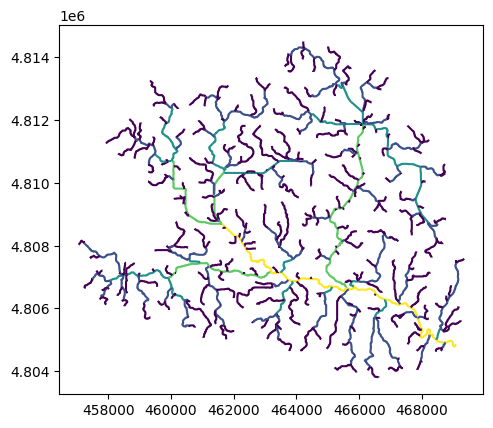

In [215]:
sub_net.plot(column = 'strmOrder')